## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
ira_data = ira_data[ira_data['AD_IMPRESSIONS']> 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].dt.time
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

2533

### Remove hyperlinks

In [9]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

### Select all duplicate ad texts

In [10]:
duplicateDF = pd.concat(g for _, g in ira_data.groupby("AD_TEXT") if len(g) > 1).copy()
duplicateDF.sort_values(by=['AD_TEXT'], inplace=True)

In [11]:
uniqueDF = ira_data.copy()
uniqueDF.drop_duplicates(subset ='AD_TEXT', 
                     keep = False, inplace = True)

### Total Duplicates

In [12]:
ira_data['AD_TEXT'].count()

2533

In [13]:
duplicateDF['AD_TEXT'].count()

614

In [14]:
uniqueDF['AD_TEXT'].count()

1919

### Unique Duplicate Pairs

In [15]:
duplicateDF['AD_TEXT'].nunique()

203

### Occurence of Duplicate Pairs

In [16]:
duplicateDF['AD_TEXT'].value_counts().values

array([13, 12,  9,  8,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [17]:
duplicateDF[(duplicateDF['AD_IMPRESSIONS']>0) & duplicateDF['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
669,91.0,1997.0,2015-06-17 03:15:18,2,2015,6,17,03:15:18,We speak for all fellow members of LGBT commun...,2673.94,144000000.0
591,5441.0,93925.0,2016-03-23 05:36:11,2,2016,3,23,05:36:11,We speak for all fellow members of LGBT commun...,31713.12,NaN
590,6566.0,67221.0,2015-11-05 23:11:58,3,2015,11,5,23:11:58,We speak for all fellow members of LGBT commun...,46994.76,36000000.0
588,21449.0,175460.0,2015-07-14 00:01:38,1,2015,7,14,00:01:38,We speak for all fellow members of LGBT commun...,93754.38,41000000.0
587,542.0,15175.0,2015-07-09 01:50:28,3,2015,7,9,01:50:28,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
586,59.0,1811.0,2015-07-07 01:51:07,1,2015,7,7,01:51:07,We speak for all fellow members of LGBT commun...,757.65,166000000.0
592,7289.0,190076.0,2016-08-04 04:20:05,3,2016,8,4,04:20:05,We speak for all fellow members of LGBT commun...,36000.00,NaN
584,3206.0,31618.0,2015-06-23 05:06:57,1,2015,6,23,05:06:57,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
583,186.0,4265.0,2015-06-22 08:19:07,0,2015,6,22,08:19:07,We speak for all fellow members of LGBT commun...,1393.55,139000000.0


### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

In [18]:
duplicateDF[['AD_CLICKS','AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET']].describe()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET
count,521.000000,614.000000,521.000000,3.890000e+02
mean,1843.264875,22629.744300,0.066887,4.091496e+07
std,5755.284818,75019.646083,0.058868,6.294265e+07
min,1.000000,1.000000,0.000089,2.900000e+04
25%,15.000000,137.250000,0.031414,5.400000e+06
50%,130.000000,1516.000000,0.054373,1.700000e+07
75%,1079.000000,12103.750000,0.086560,4.000000e+07
max,72043.000000,968768.000000,0.844262,2.520000e+08


In [19]:
uniqueDF[['AD_CLICKS','AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET']].describe()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET
count,1874.000000,1.919000e+03,1874.000000,1.338000e+03
mean,1397.125400,1.337711e+04,0.118261,2.691603e+07
std,3254.488894,4.306521e+04,0.077418,3.166521e+07
min,1.000000,1.000000e+00,0.000030,1.900000e+03
25%,64.000000,8.005000e+02,0.071083,3.000000e+06
50%,346.000000,3.970000e+03,0.119654,2.400000e+07
75%,1595.500000,1.270800e+04,0.154034,3.600000e+07
max,73063.000000,1.334544e+06,1.690789,2.530000e+08


In [20]:
ira_data[['AD_CLICKS','AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET']].describe()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET
count,2395.000000,2.533000e+03,2395.000000,1.727000e+03
mean,1494.177035,1.561995e+04,0.107085,3.006923e+07
std,3938.940267,5.275544e+04,0.076755,4.124947e+07
min,1.000000,1.000000e+00,0.000030,1.900000e+03
25%,53.000000,6.010000e+02,0.054642,3.800000e+06
50%,288.000000,3.359000e+03,0.105732,2.400000e+07
75%,1500.500000,1.265300e+04,0.146752,3.700000e+07
max,73063.000000,1.334544e+06,1.690789,2.530000e+08


### Correlations
**TODO** Handling of Outliers?, beautify the plot (axis labels, etc.)

In [21]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrDf = corrDf.dropna()

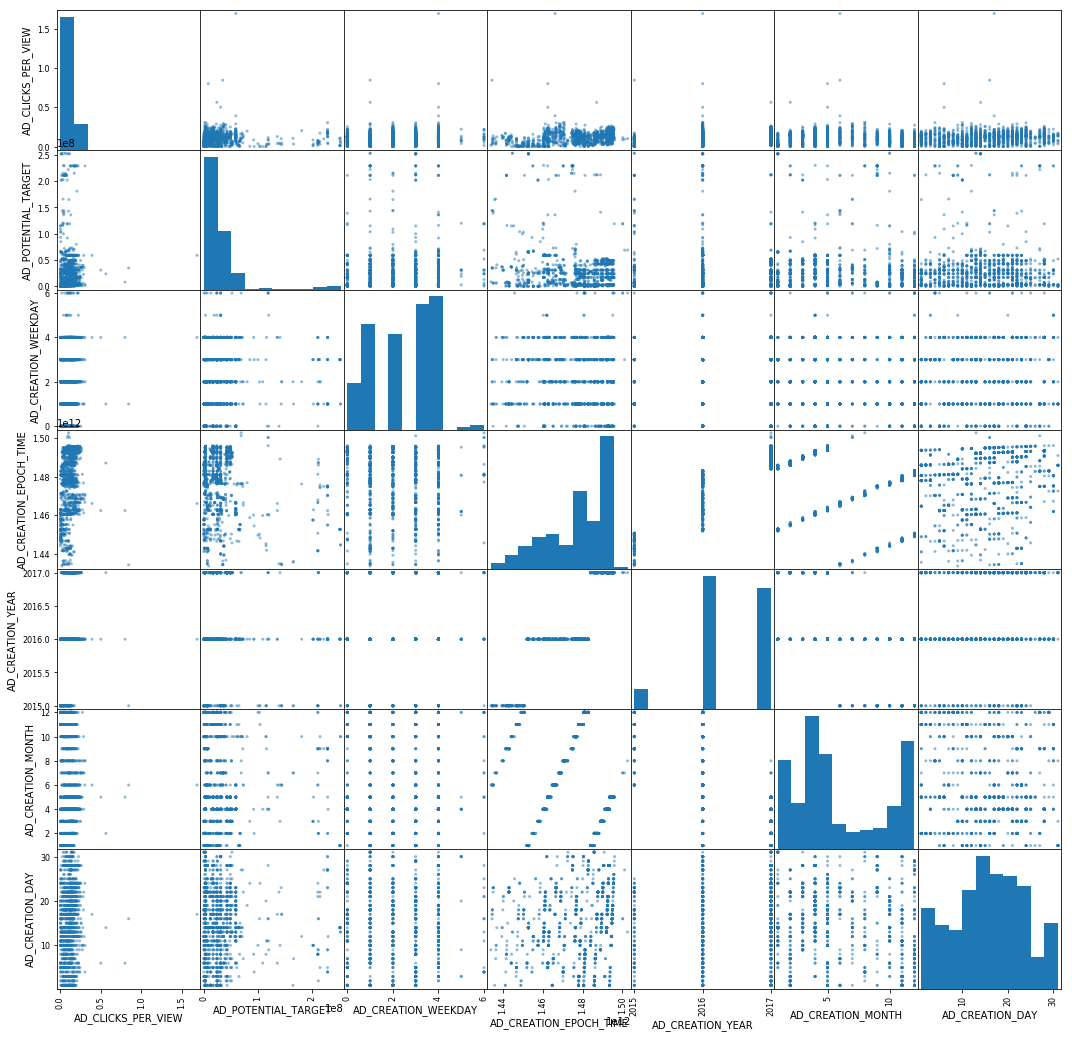

In [22]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [23]:
corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.896586,0.057780,-0.005925,0.076776,0.057474,0.010070,-0.016619
AD_IMPRESSIONS,0.896586,1.000000,-0.075717,-0.012691,-0.004104,-0.025766,0.051073,-0.042787
AD_CLICKS_PER_VIEW,0.057780,-0.075717,1.000000,-0.022267,0.250870,0.230219,-0.069586,0.120218
AD_POTENTIAL_TARGET,-0.005925,-0.012691,-0.022267,1.000000,-0.209503,-0.151152,-0.035133,-0.021093
AD_CREATION_EPOCH_TIME,0.076776,-0.004104,0.250870,-0.209503,1.000000,0.890904,-0.201071,0.196628
AD_CREATION_YEAR,0.057474,-0.025766,0.230219,-0.151152,0.890904,1.000000,-0.622880,0.199182
AD_CREATION_MONTH,0.010070,0.051073,-0.069586,-0.035133,-0.201071,-0.622880,1.000000,-0.160406
AD_CREATION_DAY,-0.016619,-0.042787,0.120218,-0.021093,0.196628,0.199182,-0.160406,1.000000


In [24]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.900011,0.455323,0.069383
AD_IMPRESSIONS,0.900011,1.000000,0.121168,0.049066
AD_CLICKS_PER_VIEW,0.455323,0.121168,1.000000,0.075039
AD_CREATION_WEEKDAY,0.069383,0.049066,0.075039,1.000000


#### Correlation: Unique Dataset

In [25]:
corrUniqueDf = uniqueDF[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrUniqueDf = corrUniqueDf.dropna()

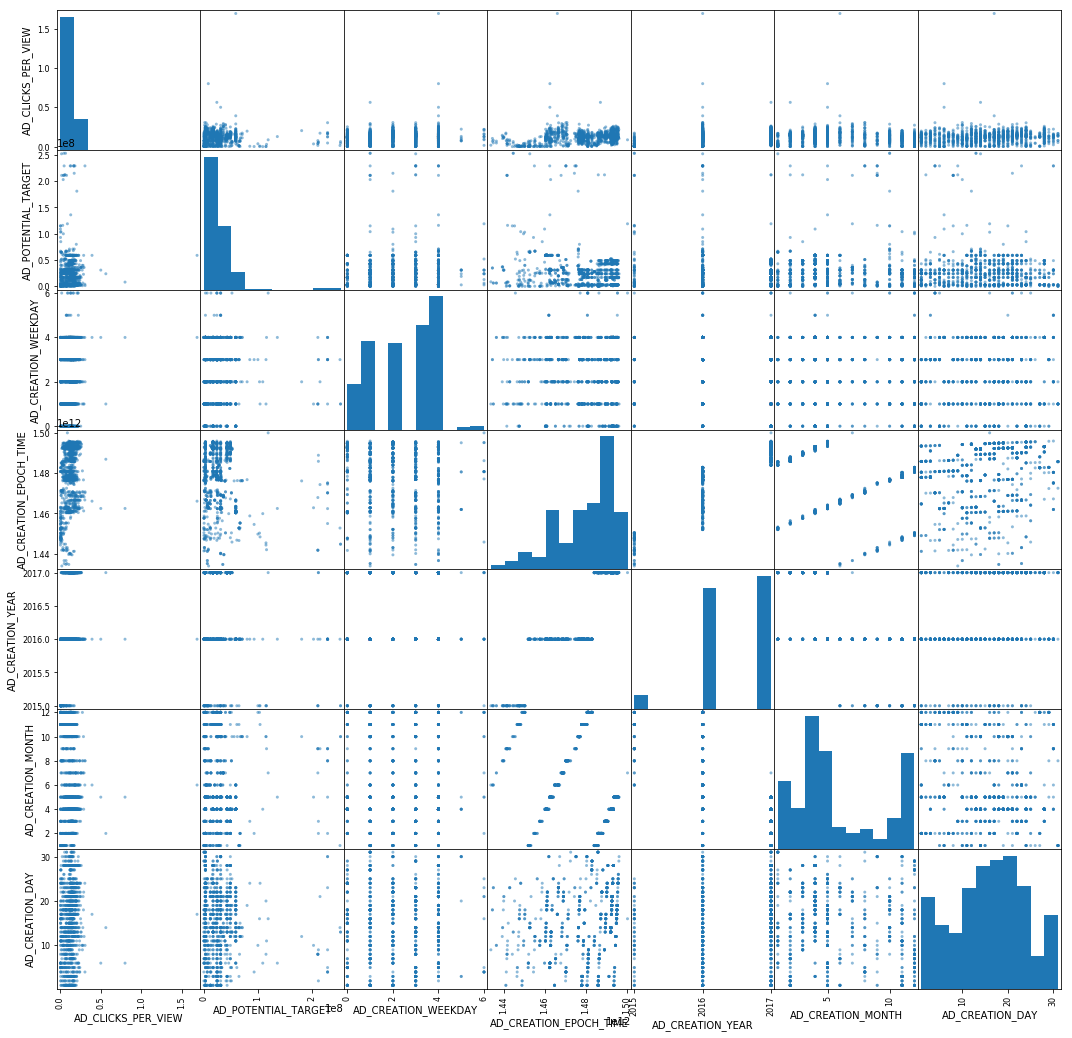

In [26]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
plt.savefig(r"../Images/scatterUnique.png")

In [27]:
corrUniqueDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.884950,0.074847,0.059113,0.188012,0.180459,-0.074015,-0.009784
AD_IMPRESSIONS,0.884950,1.000000,-0.072235,0.054292,0.053825,0.056769,-0.030566,-0.026960
AD_CLICKS_PER_VIEW,0.074847,-0.072235,1.000000,-0.012871,0.223802,0.217571,-0.101426,0.098307
AD_POTENTIAL_TARGET,0.059113,0.054292,-0.012871,1.000000,-0.230787,-0.170748,-0.012241,-0.064998
AD_CREATION_EPOCH_TIME,0.188012,0.053825,0.223802,-0.230787,1.000000,0.895014,-0.272523,0.223558
AD_CREATION_YEAR,0.180459,0.056769,0.217571,-0.170748,0.895014,1.000000,-0.671782,0.227900
AD_CREATION_MONTH,-0.074015,-0.030566,-0.101426,-0.012241,-0.272523,-0.671782,1.000000,-0.192819
AD_CREATION_DAY,-0.009784,-0.026960,0.098307,-0.064998,0.223558,0.227900,-0.192819,1.000000


In [28]:
corrUniqueDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.883487,0.425990,0.052087
AD_IMPRESSIONS,0.883487,1.000000,0.072808,0.019260
AD_CLICKS_PER_VIEW,0.425990,0.072808,1.000000,0.084507
AD_CREATION_WEEKDAY,0.052087,0.019260,0.084507,1.000000


#### Correlation: Duplicate Dataset

In [29]:
corrDuplicateDf = duplicateDF[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']]
corrDuplicateDf = corrDuplicateDf.dropna()

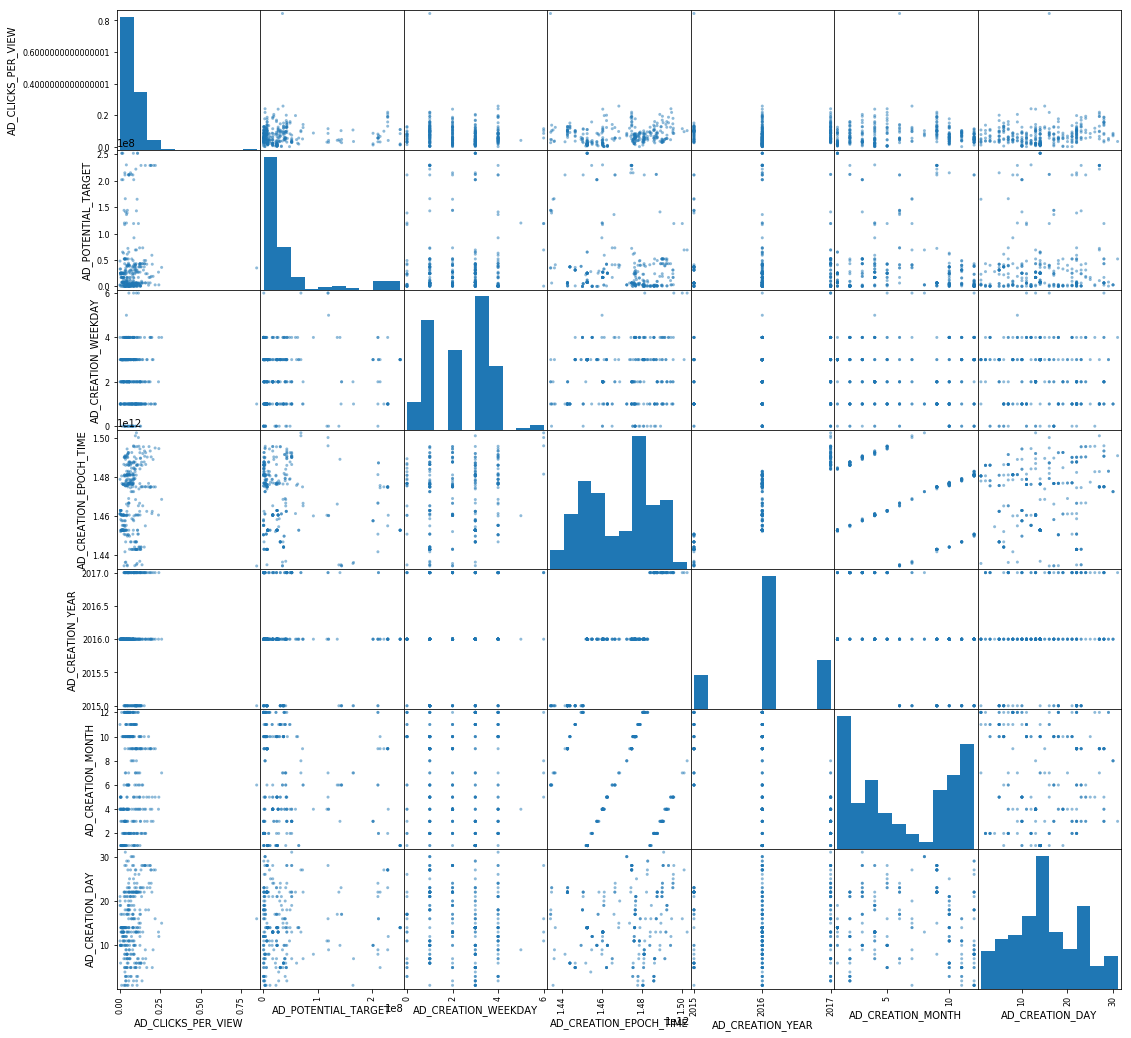

In [30]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']], figsize=(18, 18))
plt.savefig(r"../Images/scatterDuplicate.png")

In [31]:
corrDuplicateDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_DAY', 'AD_CREATION_TIME']].corr()

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY
AD_CLICKS,1.000000,0.910151,0.098749,-0.092332,-0.054929,-0.126840,0.152404,-0.026485
AD_IMPRESSIONS,0.910151,1.000000,-0.005351,-0.112633,-0.013107,-0.105701,0.183471,-0.071629
AD_CLICKS_PER_VIEW,0.098749,-0.005351,1.000000,0.071090,0.080293,0.009348,0.102496,0.194113
AD_POTENTIAL_TARGET,-0.092332,-0.112633,0.071090,1.000000,-0.114099,-0.051464,-0.094428,0.085543
AD_CREATION_EPOCH_TIME,-0.054929,-0.013107,0.080293,-0.114099,1.000000,0.849716,0.022732,0.087372
AD_CREATION_YEAR,-0.126840,-0.105701,0.009348,-0.051464,0.849716,1.000000,-0.506842,0.065092
AD_CREATION_MONTH,0.152404,0.183471,0.102496,-0.094428,0.022732,-0.506842,1.000000,-0.040122
AD_CREATION_DAY,-0.026485,-0.071629,0.194113,0.085543,0.087372,0.065092,-0.040122,1.000000


In [32]:
corrDuplicateDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.938344,0.56017,0.080601
AD_IMPRESSIONS,0.938344,1.000000,0.30774,0.133142
AD_CLICKS_PER_VIEW,0.560170,0.307740,1.00000,-0.142910
AD_CREATION_WEEKDAY,0.080601,0.133142,-0.14291,1.000000


### Regression Model (Elastic Net)
**[TODO]** ==> Julian